In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/rupertmenneer/Documents/git/bayesian_flow/')
from discretised.bfn_discretised_data import DiscretisedBimodalData
from discretised.bfn_discretised import BayesianFlowNetworkDiscretised
from bfn.models import SimpleNeuralNetworkDiscretised
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch

In [3]:
dataset = DiscretisedBimodalData(k=16)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

bfn_model = BayesianFlowNetworkDiscretised(SimpleNeuralNetworkDiscretised())
optim = AdamW(bfn_model.parameters(), lr=3e-5, betas=(0.9, 0.98), weight_decay=0.01)

epochs = 5000
losses = []
n_batches_track = 100
for i in range(epochs):
    for _, batch in enumerate(dataloader):
        optim.zero_grad()
        loss = bfn_model.continuous_time_loss_for_discretised_data(batch)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    if i%n_batches_track == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {loss.item()}')



Epoch 1/5000, Loss: 2.968200445175171
Epoch 101/5000, Loss: 2.5913755893707275
Epoch 201/5000, Loss: 1.4858430624008179
Epoch 301/5000, Loss: 1.3637042045593262
Epoch 401/5000, Loss: 0.6556450128555298
Epoch 501/5000, Loss: 0.6296399831771851
Epoch 601/5000, Loss: 0.5664989352226257
Epoch 701/5000, Loss: 0.34775081276893616
Epoch 801/5000, Loss: 0.2966737747192383
Epoch 901/5000, Loss: 0.28630656003952026
Epoch 1001/5000, Loss: 0.5686465501785278
Epoch 1101/5000, Loss: 0.30251386761665344
Epoch 1201/5000, Loss: 0.36619704961776733
Epoch 1301/5000, Loss: 0.33322596549987793
Epoch 1401/5000, Loss: 0.18407876789569855
Epoch 1501/5000, Loss: 0.504982590675354
Epoch 1601/5000, Loss: 0.35429757833480835
Epoch 1701/5000, Loss: 0.287403404712677
Epoch 1801/5000, Loss: 0.36485961079597473
Epoch 1901/5000, Loss: 0.3751983940601349
Epoch 2001/5000, Loss: 0.3435916304588318
Epoch 2101/5000, Loss: 0.5638240575790405
Epoch 2201/5000, Loss: 0.3642788231372833
Epoch 2301/5000, Loss: 0.3367536962032318

Text(0.5, 1.0, 'Training loss')

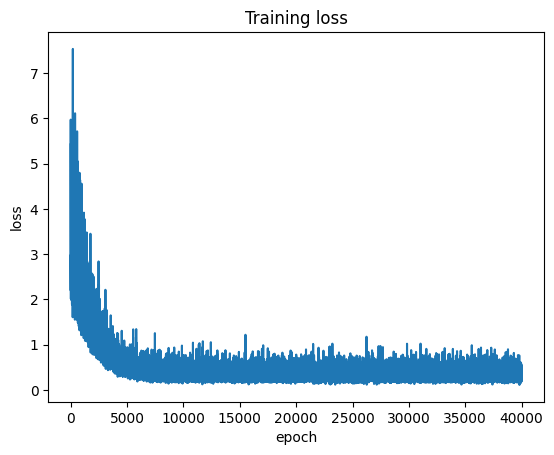

In [4]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')

This example is 1 DIMENSIONAL (D), with 16 BINS (K)

In [6]:
dataset = DiscretisedBimodalData(k=16)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
batch = next(iter(dataloader))
print(batch.shape)
# plt.hist(batch.numpy(), bins=16)

torch.Size([1024, 1])


# Sample generation

Text(0.5, 1.0, 'Samples from Discretised BFN model')

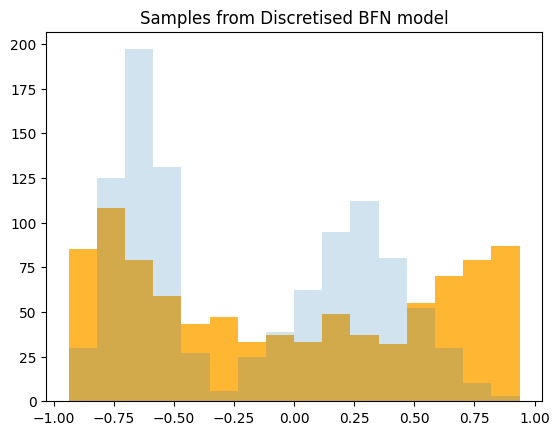

In [15]:
samples = bfn_model.sample_generation_for_discretised_data(n_steps=50, bs=1024).to(torch.float32)
plt.hist(samples.detach().numpy(), alpha=0.8, bins=16, label='BFN Samples', color='orange')
plt.hist(batch.numpy(), bins=16, alpha=0.2, label='True Samples')
plt.title('Samples from Discretised BFN model')

In [ ]:
 ls ../bfn_github/

In [ ]:

from bfn_github.bfn import BayesianFlowNetwork
import torch
# network should learn:
# when x0 = 0, x1 = 1
# when x0 = 1, x1 = 0
def get_datapoint(batch=128, device='cpu'):
    x0 = torch.randint(0, 2, size=(batch,), dtype=torch.bool, device=device)
    x1 = ~x0

    X = torch.stack([x0, x1], dim=0)
    return X.long().transpose(0, 1)

X = get_datapoint()  # (B, D=2) with K=2 classes 
print(X.shape)
# plt.title("Dataset")
# plt.scatter(X[:, 0], X[:, 1]);
# plt.grid()

from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork()

optim = AdamW(bfn.parameters(), lr=1e-2)


n = 1000
losses = []
for i in tqdm(range(n)):
    optim.zero_grad()
    X = get_datapoint(device='cpu')
    loss = bfn.process(X)
    loss.backward()
    optim.step()
    losses.append(loss.item())

bfn.sample(16)

In [ ]:
torch.nn.functional.one_hot(torch.tensor([2, 1]).unsqueeze(0), num_classes=3)
def vectorised_discretised_cdf(mu, sigma, bounds):
    # input is mu, sigma -> B x D, and bounds -> K
    lower_mask = bounds < -1
    upper_mask = bounds > 1

    # output is B x D x K
    result = torch.zeros(mu.shape[0], mu.shape[1], bounds.shape[0])
    result = 0.5 * (1 + torch.erf((bounds - mu.unsqueeze(-1)) / (sigma.unsqueeze(-1) * torch.sqrt(torch.tensor(2.0)))))
    # clip result depending on boundsa
    result[:, :, lower_mask] = 0
    result[:, :, upper_mask] = 1

    return result

mu = torch.randn(2, 2)
sigma = torch.ones(2, 2)
bounds = torch.linspace(-1.1, 1.1, 4)

cdf = vectorised_discretised_cdf(mu, sigma, bounds)

print(cdf)